In [2]:
import pickle
import numpy as np
import pandas as pd
import multiprocessing
import my_functions as my
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Importing the data
data = np.loadtxt('zipcombo.dat')

y = data[:, 0]
X = data[:, 1:]

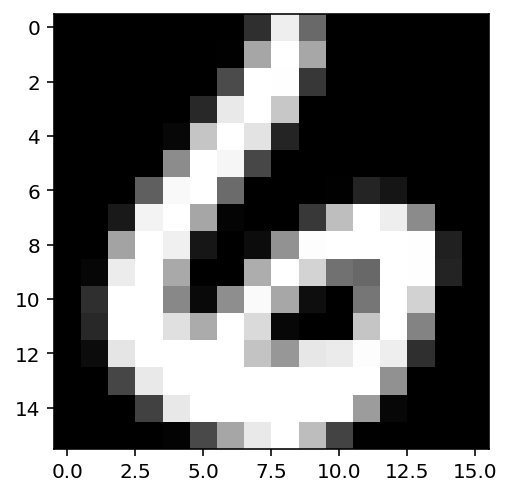

In [4]:
plt.imshow(X[0].reshape(16,16), cmap = 'gray');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


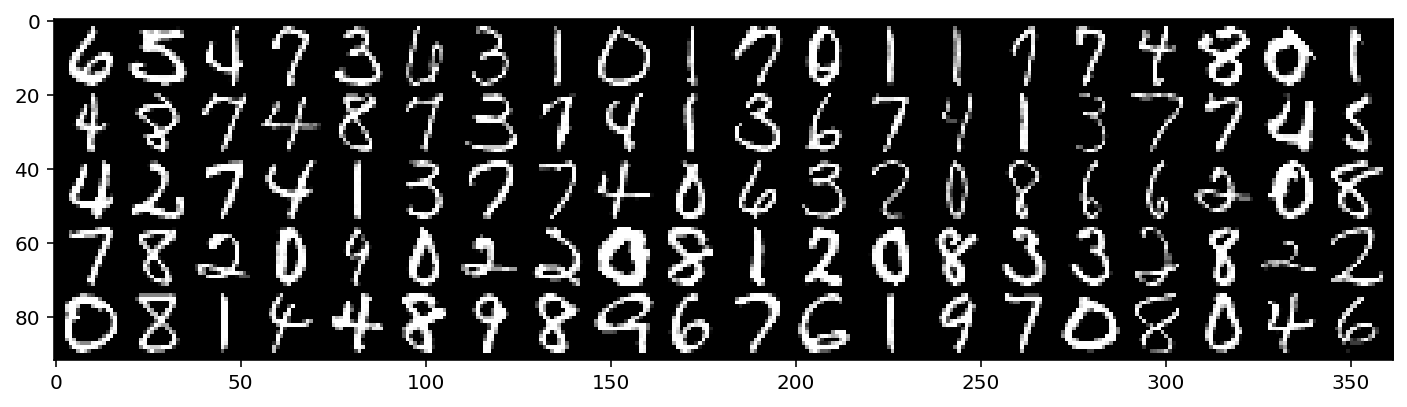

In [5]:
# Visualising a sample of the data
# Importing torch utilities just for plotting
import torch

from torchvision.utils import make_grid

plotting = torch.Tensor(X.reshape(-1,1,16,16))
plt.figure(figsize = (12,4))
plt.imshow(make_grid(plotting[:100], nrow = 20).permute(1,2,0));

# Data preparation and training routines

In [6]:
def poly_kernel_matrix(X1, X2, d):
    """Fast computation of the polynomial kernel matrix for a given dataset."""
    gram = X1 @ X2.T
    return gram ** d

In [7]:
def gaussian_kernel_matrix(X1, X2, gamma):
    """Fast computation of the Gaussian kernel matrix for a given dataset.
    """
    
    # Take the squared norms of each row
    squared_norm1 = np.sum(X1** 2, axis = 1)
    squared_norm2 = np.sum(X2 ** 2, axis = 1)
    
    # Exploiting the identity: ||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x^T * y  and numpy broadcasting
    K = np.exp(-gamma * (squared_norm1[:, None] + squared_norm2[None, :] - 2 * X1 @ X2.T))
    
    return K

In [8]:
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = 2020)

In [9]:
def signed_one_hot(y, classes = 10):
    """Produces a one_hot encoding of the given vector of labels.
    
    Args:
    y (ndarray): vector of labels to encode
    classes (int): number of classes to encode represented in y. Default is 10 for our case.
    
    Returns:
    Y_one_hot (ndarray): matrix of shape (len(y), classes) of one hot encoded y
    """
    
    # Initialise matrix of negative ones
    Y_one_hot = - np.ones((len(y), classes))
    
    # Fancy indexing to get "one hot". Assigning 1 to element at position y in every row
    Y_one_hot[range(y.shape[0]), (y.astype(int))] = 1
    
    return Y_one_hot


In [10]:
def train_test_perceptron_fast(X_train, y_train, X_test, Y_test, epochs = 5):
    """Main training routine for the one vs all multi-class kernel perceptron.
    Epochs are run in iterative mode. NOTE: this function is only here for hyperparameter testing.
    Mathematical justification of its functioning is rather handwavy"""
    
    # Matrix of alpha which each row represent each of the 10 classes, change column value after each iteration
    
    alpha = np.ones((10,len(X_train))) #  Initialise alphas to zeros
    
    for epoch in range(1, epochs):
        train_mistakes = 0
        for t in range(len(X_train)):

            WX = alpha[:,:t] @ X_train[:t,t].reshape(-1,1) # this is the summation term 

            for i in range(WX.shape[0]):
                if y_train[t,i] * np.squeeze(WX)[i] <= 0:
                    alpha[:,t][i] -=  np.sign(np.squeeze(WX)[i])

    # Batch predict all of the test data to get test accuracy
    
    train_mistakes = 0
    WX_train = (alpha @ X_train).T
    Y_pred_train = - np.ones_like(WX_train)
    Y_pred_train[range(y_train.shape[0]), np.argmax(WX_train, axis = 1)] = 1 
    train_mistakes = (Y_pred_train != y_train).sum() / 2
    
    test_mistakes = 0
    WX_test = (alpha @ X_test).T
    Y_pred_test = - np.ones_like(WX_test)
    Y_pred_test[range(Y_test.shape[0]), np.argmax(WX_test, axis = 1)] = 1 

    test_mistakes = (Y_pred_test != Y_test).sum() / 2  # By comparing them like this when there is a mistake we count it two times

    train_accuracy, test_accuracy = (len(X_train) - train_mistakes)/(len(X_train)), ((X_test.shape[1]) - test_mistakes)/((X_test.shape[1]))

    return train_accuracy, test_accuracy, alpha

In [11]:
def train_test_perceptron_tile(X_train, y_train, X_test, Y_test, epochs = 5):
    """Main training routine for the one vs all multi-class kernel perceptron.
    Epochs are run in tiling mode."""
    
    # Matrix of alpha which each row represent each of the 10 classes, change column value after each iteration   
    y_train = np.tile(y_train.T, epochs).T
    
    A = np.tile(X_train.T,epochs).T
    X_train =np.tile(A, epochs)
    X_test =np.tile(X_test.T, epochs).T
    
    alpha = np.zeros((10,len(X_train))) #  Initialise alphas to zeros

    train_mistakes = 0
    for t in range(len(X_train)):

        WX = alpha[:,:t] @ X_train[:t,t].reshape(-1,1) # this is the summation term 
        
        # print(f'{y_train[t,:]=}')
        # print(f'{np.squeeze(WX)=}')

        for i in range(10):
            if y_train[t,i] * np.squeeze(WX)[i] <= 0:
                alpha[:,t][i] -=  my.sign(np.squeeze(WX)[i])

    train_mistakes = 0
    WX_train = (alpha @ X_train).T
    Y_pred_train = - np.ones_like(WX_train)
    Y_pred_train[range(y_train.shape[0]), np.argmax(WX_train, axis = 1)] = 1 
    train_mistakes = (Y_pred_train != y_train).sum() / 2
    # Batch predict all of the test data to get test accuracy
    
    test_mistakes = 0
    WX_test = (alpha @ X_test).T
    Y_pred_test = - np.ones_like(WX_test)
    Y_pred_test[range(Y_test.shape[0]), np.argmax(WX_test, axis = 1)] = 1 

    test_mistakes = (Y_pred_test != Y_test).sum() / 2  # By comparing them like this when there is a mistake we count it two times
    train_accuracy = (X_train.shape[1] - train_mistakes)/(X_train.shape[1])
    test_accuracy = ((X_test.shape[1]) - test_mistakes)/((X_test.shape[1]))
    
    return train_accuracy, test_accuracy, alpha

In [13]:
poly_order = 7
y_train_hot = signed_one_hot(y_train)
y_test_hot = signed_one_hot(y_test)
K_train, K_test = poly_kernel_matrix(X_train, X_train, poly_order), poly_kernel_matrix(X_train, X_test, poly_order)  
train_accuracy, test_accuracy, alpha = train_test_perceptron_fast(K_train, y_train_hot, K_test, y_test_hot, 50)
print(f'{train_accuracy = :.3f}')
print(f'{test_accuracy = :.3f}')

train_accuracy = 0.994
test_accuracy = 0.966


In [14]:
# # To check after how many epochs we converge
losses_train = []
losses_test = []
K_train, K_test = poly_kernel_matrix(X_train, X_train, poly_order), poly_kernel_matrix(X_train, X_test, poly_order)  
for epoch in range(1,6):
    train_accuracy, test_accuracy, alpha = train_test_perceptron_tile(K_train, y_train_hot, K_test, y_test_hot, epoch)
    losses_train.append(1-train_accuracy)
    losses_test.append(1-test_accuracy)
plt.plot(list(range(1,6)), losses_train);
plt.plot(list(range(1,6)), losses_test);

KeyboardInterrupt: 

# Protocol 1

In [ ]:
# Comment on how many epochs you chose to use
def multi_run_polynomial(data, epochs = 10, degrees = None, runs = 20):
    """Runs the kernel perceptron multiple times with different polynomial orders and train-test splits"""
    # Split labels from samples
    y = data[:, 0]
    X = data[:, 1:]
    
    # Initialise polynomial degrees if not given
    if degrees is None:
        degrees = list(range(1, 8))
    
    train_losses = np.zeros((len(degrees), runs))
    test_losses = np.zeros((len(degrees), runs))
    
    for run in trange(runs):
        
        # Randomply split train and test data at each run
        X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(100))
        y_train_hot = signed_one_hot(y_train)
        y_test_hot = signed_one_hot(y_test)
        
        for degree in degrees:
            K_train, K_test = poly_kernel_matrix(X_train, X_train, degree), poly_kernel_matrix(X_train, X_test, degree)
            train_accuracy, test_accuracy, _ = train_test_perceptron_tile(K_train, y_train_hot, K_test, y_test_hot, epochs)
            train_losses[degree-1, run] = train_accuracy
            test_losses[degree-1, run] = test_accuracy
    return train_losses, test_losses

In [ ]:
train_losses, test_losses = multi_run_polynomial(data, epochs = 4)
my.save_obj(train_losses, 'train_losses_poly_20')
my.save_obj(test_losses, 'test_losses_poly_20')

100%|██████████| 20/20 [1:56:56<00:00, 350.85s/it]


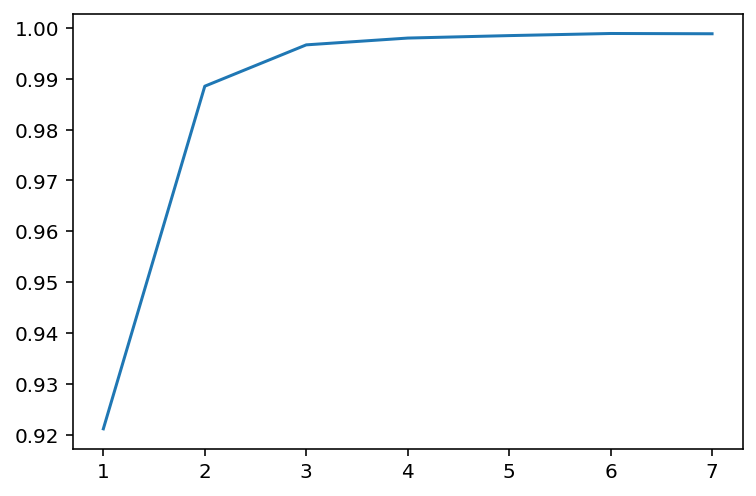

In [ ]:
plt.plot(np.arange(1,8), train_losses.mean(axis = 1));

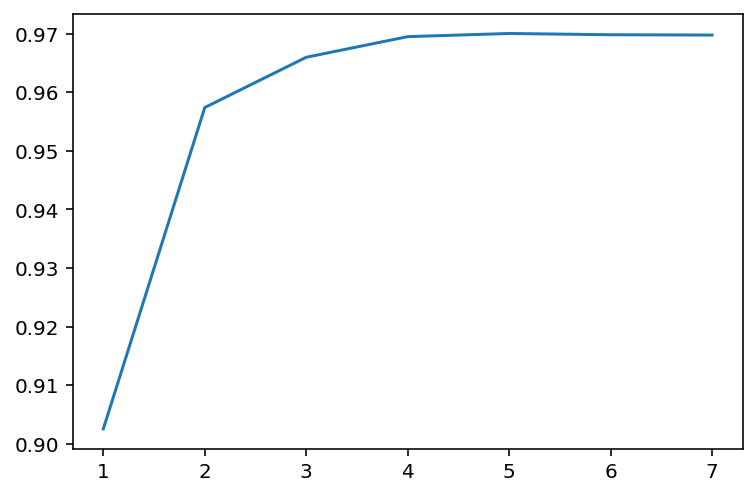

In [ ]:
plt.plot(np.arange(1,8), test_losses.mean(axis = 1));

In [91]:
# # this gives the true label of just one test instance
def plot_predict(X_test, y_test, K_test, alpha, which_y = 0):
    
    # checking for one hot, can work even without it:
    if np.atleast_2d(y_test).shape[0] == 1:
        y_test = signed_one_hot(y_test)

    this_pred = (alpha @ K_test[:,which_y]).T
    Y_pred_test = np.zeros_like(this_pred)
    Y_pred_test[np.argmax(this_pred)] = 1 
    confidence = this_pred/np.sum(np.clip(this_pred, 0.0001, np.Inf)) # Get "confidence" in each label by "normalising". Clipping negative values to 0
    
    predicted_label = np.argmax(Y_pred_test)
    true_label = np.argmax(y_test[which_y,:])
    
    print(f"Predicted label for test item n. {which_y} is {predicted_label} with confidence {np.max(confidence):.2f}.")
    print(f"True label is {true_label}")
    
    plt.imshow(X_test[which_y].reshape(16,16), cmap = 'gray');

plot_predict(X_test, y_test, K_test, alpha, 1858)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7439 is different from 14878)

In [15]:
def store_mistakes(y_test, K_test, alpha):
    
    true_labels = []
    predicted_labels = []
    
    for which_y in range(y_test.shape[0]):
        if np.atleast_2d(y_test).shape[0] == 1:
            y_test = signed_one_hot(y_test)

        this_pred = (alpha @ K_test[:,which_y]).T
        Y_pred_test = np.zeros_like(this_pred)
        Y_pred_test[np.argmax(this_pred)] = 1         
        predicted_label = np.argmax(Y_pred_test)
        true_label = np.argmax(y_test[which_y,:])
        
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        
    true_labels = np.array(true_labels).astype(int)
    predicted_labels = np.array(predicted_labels).astype(int)
    
    indexes = np.arange(y_test.shape[0])
    indexes = indexes[true_labels != predicted_labels]
    true_mistaken = true_labels[true_labels != predicted_labels]
    predicted_mistaken = predicted_labels[true_labels != predicted_labels]
    
    return(np.concatenate((indexes[:, None], true_mistaken[:, None], predicted_mistaken[:, None]), axis = 1))

In [17]:
def calc_confusion_matrix(mistakes_array):
    """Inefficient calculation of the confusion matrix for a given array of mistakes"""
    
    confusion_matrix = np.zeros((10,10))
    for el in mistakes_array:
        if el[1] != el [2]:
            confusion_matrix[el[1],el[2]] += 1
    return confusion_matrix

# Protocol 2

In [19]:
def cross_validate_polynomial(data, n_splits = 5, cross_epochs = 10,  epochs = 10, degrees = None, runs = 20):
    
    
    # Initialise polynomial degrees if not given
    if degrees is None:
        degrees = list(range(1, 8))
    
    # Split labels from samples
    y = data[:, 0]
    X = data[:, 1:]
    
    confusions = []
    train_losses = np.zeros((len(degrees), runs, n_splits))
    val_losses = np.zeros((len(degrees), runs, n_splits))
    best_degrees = np.zeros((runs))
    test_accuracies = np.zeros((runs))
    wrong_images = []
    
    for run in tqdm(range(runs), desc = 'Runs'):
            
        # Randomply split train and test data
        X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(100))
        
        y_train = y_train[:, None]
        y_test = y_test[:, None]
        
        for i_split, (train_indices, val_indices) in enumerate(my.cross_validation_split(X_train, n_splits)):
            print(f'Running the {i_split + 1} split of cross validation in run {run + 1}')

            # Split the training data into cross-validation training and validation sets
            X_cv_train = X_train[train_indices,:]
            y_cv_train = y_train[train_indices,:]
            X_cv_val = X_train[val_indices,:]
            y_cv_val = y_train[val_indices,:]
            # Prepare data to run: one-hot the ys
            y_cv_train_hot = signed_one_hot(np.squeeze(y_cv_train))     # Need to squeeze for compatibility with one-hot validation function
            y_cv_val_hot = signed_one_hot(np.squeeze(y_cv_val))
            for degree in degrees:
                K_cv_train, K_cv_val = poly_kernel_matrix(X_cv_train, X_cv_train, degree), poly_kernel_matrix(X_cv_train, X_cv_val, degree)
                train_accuracy, validation_accuracy, _ = train_test_perceptron_tile(K_cv_train, y_cv_train_hot, K_cv_val, y_cv_val_hot, cross_epochs)
                train_losses[degree-1, run, i_split] = train_accuracy
                val_losses[degree-1, run, i_split] = validation_accuracy
                
        # Extract and save current best degree
        best_degree = np.argmax(np.mean(val_losses[:, run, :], axis = 1)) + 1 # To counter python indexing
        best_degrees[run] = int(best_degree)
        
        
        # Retrain on the test set using best degree
        y_train_hot = signed_one_hot(np.squeeze(y_train))  # Need to squeeze to counter dimension augmentation: compatibility with one hot function
        y_test_hot = signed_one_hot(np.squeeze(y_test))
        K_train, K_test = poly_kernel_matrix(X_train, X_train, int(best_degree)), poly_kernel_matrix(X_train, X_test, int(best_degree))
        
        
        _, test_accuracy, alpha = train_test_perceptron_tile(K_train, y_train_hot, K_test, y_test_hot, epochs)
        test_accuracies[run] = test_accuracy
        
        K_test_tiled = np.tile(K_test.T, epochs).T
        mistakes = store_mistakes(np.squeeze(y_test), K_test_tiled, alpha) # check mistakes
        # save mistaken images
        mistake_indexes = mistakes[:,0]
        mistake_images = X_test[mistake_indexes].tolist()
        wrong_images += mistake_images
        
        # Calculate confusion matrix
        confusion_matrix = calc_confusion_matrix(mistakes)
        confusions.append(confusion_matrix)
        
    return train_losses, val_losses, best_degrees, test_accuracies, confusions, wrong_images
        
train_losses, val_losses, best_degrees, test_accuracies, confusions, wrong_images = cross_validate_polynomial(data, n_splits = 5, cross_epochs = 3,  epochs = 4, degrees = None, runs = 20)

np.save('train_losses_cross_poly', train_losses)
np.save('val_losses_cross_poly', val_losses)
np.save('best_degrees_poly', best_degrees)
np.save('test_accuracies_cross_poly', test_accuracies)
np.save('polynomial_confusions', confusions)
my.save_obj(wrong_images, 'wrong_images_poly')

Runs:   0%|          | 0/20 [00:00<?, ?it/s]

Running the 1 split of cross validation in run 1
Running the 2 split of cross validation in run 1
Running the 3 split of cross validation in run 1
Running the 4 split of cross validation in run 1
Running the 5 split of cross validation in run 1


Runs:   5%|▌         | 1/20 [12:53<4:05:01, 773.79s/it]

Running the 1 split of cross validation in run 2
Running the 2 split of cross validation in run 2
Running the 3 split of cross validation in run 2
Running the 4 split of cross validation in run 2
Running the 5 split of cross validation in run 2


Runs:  10%|█         | 2/20 [23:12<3:24:44, 682.46s/it]

Running the 1 split of cross validation in run 3
Running the 2 split of cross validation in run 3
Running the 3 split of cross validation in run 3
Running the 4 split of cross validation in run 3
Running the 5 split of cross validation in run 3


Runs:  15%|█▌        | 3/20 [33:45<3:07:00, 660.04s/it]

Running the 1 split of cross validation in run 4
Running the 2 split of cross validation in run 4
Running the 3 split of cross validation in run 4
Running the 4 split of cross validation in run 4
Running the 5 split of cross validation in run 4


Runs:  20%|██        | 4/20 [42:14<2:40:04, 600.26s/it]

Running the 1 split of cross validation in run 5
Running the 2 split of cross validation in run 5
Running the 3 split of cross validation in run 5
Running the 4 split of cross validation in run 5
Running the 5 split of cross validation in run 5


Runs:  25%|██▌       | 5/20 [53:37<2:37:32, 630.20s/it]

Running the 1 split of cross validation in run 6
Running the 2 split of cross validation in run 6
Running the 3 split of cross validation in run 6
Running the 4 split of cross validation in run 6
Running the 5 split of cross validation in run 6


Runs:  30%|███       | 6/20 [1:00:52<2:11:34, 563.86s/it]

Running the 1 split of cross validation in run 7
Running the 2 split of cross validation in run 7
Running the 3 split of cross validation in run 7
Running the 4 split of cross validation in run 7
Running the 5 split of cross validation in run 7


Runs:  35%|███▌      | 7/20 [1:07:39<1:51:01, 512.43s/it]

Running the 1 split of cross validation in run 8
Running the 2 split of cross validation in run 8
Running the 3 split of cross validation in run 8
Running the 4 split of cross validation in run 8
Running the 5 split of cross validation in run 8


Runs:  40%|████      | 8/20 [1:14:07<1:34:33, 472.82s/it]

Running the 1 split of cross validation in run 9
Running the 2 split of cross validation in run 9
Running the 3 split of cross validation in run 9
Running the 4 split of cross validation in run 9
Running the 5 split of cross validation in run 9


Runs:  45%|████▌     | 9/20 [1:21:42<1:25:40, 467.27s/it]

Running the 1 split of cross validation in run 10
Running the 2 split of cross validation in run 10
Running the 3 split of cross validation in run 10
Running the 4 split of cross validation in run 10
Running the 5 split of cross validation in run 10


Runs:  50%|█████     | 10/20 [1:29:36<1:18:12, 469.27s/it]

Running the 1 split of cross validation in run 11
Running the 2 split of cross validation in run 11
Running the 3 split of cross validation in run 11
Running the 4 split of cross validation in run 11
Running the 5 split of cross validation in run 11


Runs:  55%|█████▌    | 11/20 [1:37:35<1:10:50, 472.32s/it]

Running the 1 split of cross validation in run 12
Running the 2 split of cross validation in run 12
Running the 3 split of cross validation in run 12
Running the 4 split of cross validation in run 12
Running the 5 split of cross validation in run 12


Runs:  60%|██████    | 12/20 [1:45:40<1:03:30, 476.33s/it]

Running the 1 split of cross validation in run 13
Running the 2 split of cross validation in run 13
Running the 3 split of cross validation in run 13
Running the 4 split of cross validation in run 13
Running the 5 split of cross validation in run 13


Runs:  65%|██████▌   | 13/20 [1:52:56<54:07, 464.00s/it]  

Running the 1 split of cross validation in run 14
Running the 2 split of cross validation in run 14
Running the 3 split of cross validation in run 14
Running the 4 split of cross validation in run 14
Running the 5 split of cross validation in run 14


Runs:  70%|███████   | 14/20 [2:00:43<46:30, 465.05s/it]

Running the 1 split of cross validation in run 15
Running the 2 split of cross validation in run 15
Running the 3 split of cross validation in run 15
Running the 4 split of cross validation in run 15
Running the 5 split of cross validation in run 15


Runs:  75%|███████▌  | 15/20 [2:07:44<37:38, 451.75s/it]

Running the 1 split of cross validation in run 16
Running the 2 split of cross validation in run 16
Running the 3 split of cross validation in run 16
Running the 4 split of cross validation in run 16
Running the 5 split of cross validation in run 16


Runs:  80%|████████  | 16/20 [2:14:51<29:36, 444.14s/it]

Running the 1 split of cross validation in run 17
Running the 2 split of cross validation in run 17
Running the 3 split of cross validation in run 17
Running the 4 split of cross validation in run 17
Running the 5 split of cross validation in run 17


Runs:  85%|████████▌ | 17/20 [2:22:34<22:29, 449.89s/it]

Running the 1 split of cross validation in run 18
Running the 2 split of cross validation in run 18
Running the 3 split of cross validation in run 18
Running the 4 split of cross validation in run 18
Running the 5 split of cross validation in run 18


Runs:  90%|█████████ | 18/20 [2:32:16<16:19, 489.55s/it]

Running the 1 split of cross validation in run 19
Running the 2 split of cross validation in run 19
Running the 3 split of cross validation in run 19
Running the 4 split of cross validation in run 19
Running the 5 split of cross validation in run 19


Runs:  95%|█████████▌| 19/20 [2:41:43<08:32, 512.73s/it]

Running the 1 split of cross validation in run 20
Running the 2 split of cross validation in run 20
Running the 3 split of cross validation in run 20
Running the 4 split of cross validation in run 20
Running the 5 split of cross validation in run 20


Runs: 100%|██████████| 20/20 [2:52:25<00:00, 517.29s/it]


In [123]:
# load objects if they are not already in the environment
if confusions is None:
    confusions = np.load('polynomial_confusions.npy')
    train_losses = np.load('train_losses_cross_poly.npy')
    val_losses = np.load('val_losses_cross_poly.npy')
    best_degrees = np.load('best_degrees_poly.npy')
    test_accuracies = np.load('test_accuracies_cross_poly.npy')
    wrong_images = my.load_obj('wrong_images_poly.pkl')

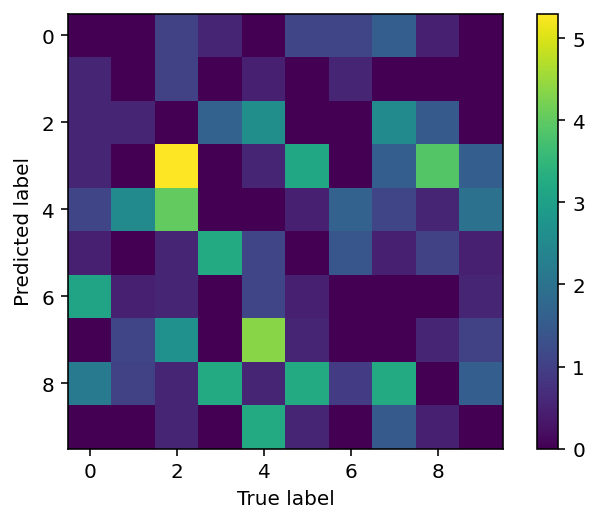

In [139]:
mean_confusion = np.stack(confusions, axis = 2).mean(2)
std_confusion = np.stack(confusions, axis = 2).std(2)
plt.imshow((mean_confusion / (np.sum(mean_confusion)) * 100), cmap = "viridis")
plt.xticks(list(range(0, 10)))
plt.yticks(list(range(0, 10)))
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Mean confusion matrix')
plt.colorbar();


# Extracting mistakes

In [28]:
wrong_array = np.stack(wrong_images, axis = 0) # create array of images gotten wrong - it will include multiple copies of some

temp_array = [tuple(row) for row in wrong_array]
uniques = np.unique(temp_array, axis = 0, return_counts = True) # Get just unique images with counts of how many times they appear
unique_array = np.array(uniques[0]) # Extract only the images
counts = uniques[1] # Extract only the counts

images_with_counts = np.concatenate((counts[:,None], unique_array), axis = 1) # Concatenate them together
sorted_counts = images_with_counts[np.argsort(images_with_counts[:, 0], )]
sorted_counts = np.copy(sorted_counts[::-1]) # Sort by counts and order descendingly

difficult_images = sorted_counts[:5,1:] # Get only the five we care about

In [29]:
# plot
plt.imshow(difficult_images[4].reshape(16,16), cmap = 'gray');

(1177, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


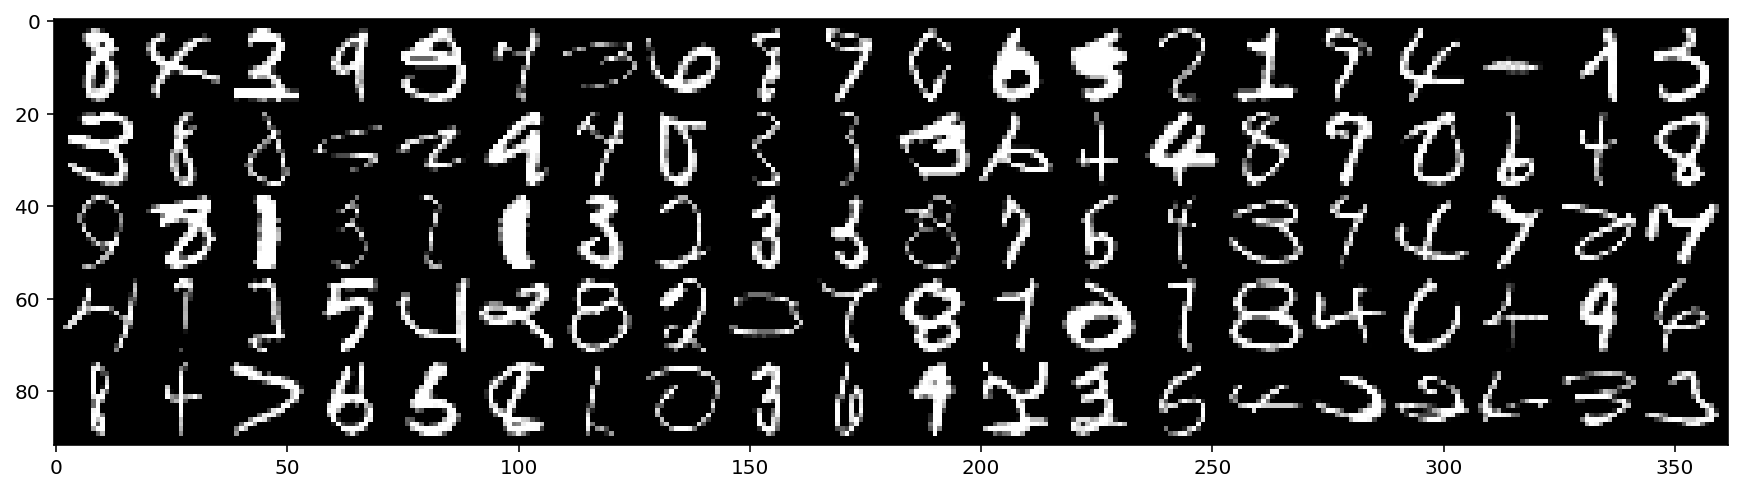

In [120]:
# Visualising a bunch of misclassified images.
import torch

from torchvision.utils import make_grid

plotting = torch.Tensor(sorted_counts[:101,1:].reshape(-1,1,16,16))
plt.figure(figsize = (15,5))
plt.imshow(make_grid(plotting[:100], nrow = 20).permute(1,2,0));